In [ ]:
import numpy as np, os, pickle
import pandas as pd
import matplotlib
import re


We open the file as a picke

In [ ]:
file_name  = r'C:\Users\chriq\OneDrive\Documents\my_data\MLdata\JS_Obfuscation_df.zip'
data=pd.read_pickle(file_name)

In [ ]:
data.head()

,js_filename,class,obfuscation_mode,js,obfuscator_name
0,data/007design/Formular/scripts/view.dashboard.js,cleartext,N/A,"function DashboardCtrl($scope, $http, $filter,...",NaN
1,data/01org/appframeworkMVC/src/controller.js,cleartext,N/A,/**\n * @Copyright Intel 2013\n * @Author Ian ...,NaN
2,data/01org/appframeworkMVC/starter/appframewor...,cleartext,N/A,/**\n* App Framwork query selector class for ...,NaN
3,data/01org/rib/src/js/composer.js,cleartext,N/A,/*\n * Rapid Interface Builder (RIB) - A simpl...,NaN
4,data/01org/rib/src/js/devices.js,cleartext,N/A,/*\n * Rapid Interface Builder (RIB) - A simpl...,NaN


# Data Exploration

Our data has ~190,000 lines, and our columns are:
- js_filename: name of the file
- class: cleartext or obfuscated
- obfuscation_mode: 
- js: contains the JS code we analyze
- obfuscator_name: If obfuscated, contains the name of the obfuscator

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189395 entries, 0 to 189394
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   js_filename       189395 non-null  object
 1   class             189395 non-null  object
 2   obfuscation_mode  189395 non-null  object
 3   js                189395 non-null  object
 4   obfuscator_name   93011 non-null   object
dtypes: object(5)
memory usage: 7.2+ MB


In [ ]:
data['class'].value_counts()

cleartext     96384
obfuscated    93011
Name: class, dtype: int64

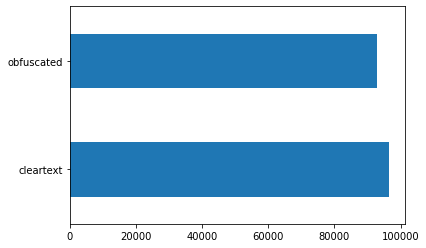

In [ ]:
data['class'].value_counts().plot(kind = 'barh')

In [ ]:
data['obfuscation_mode'].value_counts()

N/A            96384
Unknown        85846
OnlyOneMode     4900
1                817
2                729
3                719
Name: obfuscation_mode, dtype: int64

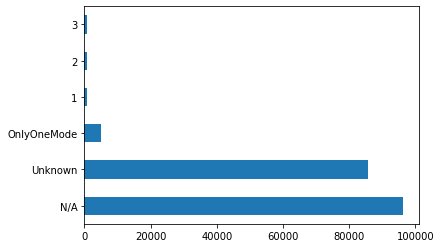

In [ ]:
data['obfuscation_mode'].value_counts().plot(kind = 'barh')

In [ ]:
data['obfuscator_name'].value_counts()

jsobfu           23616
obfuscator_io    23535
jfogs            23165
defendjs         22695
Name: obfuscator_name, dtype: int64

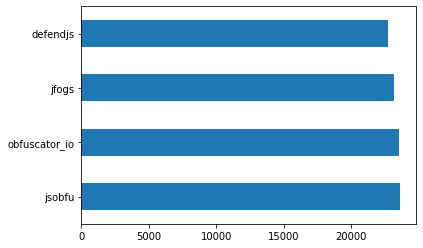

In [ ]:
data['obfuscator_name'].value_counts().plot(kind = 'barh')

Memory usage: The original file needs 7.9+ billion bytes (Gigabytes)

In [ ]:
data.memory_usage(index=True, deep=True)

Index                      128
js_filename           24651392
class                 20540925
obfuscation_mode      16284290
js                  7831058216
obfuscator_name       12483139
dtype: int64

In [ ]:
data.memory_usage(index=True, deep=True).sum()

7905018090

# Formatting the data


Some columns are less relevant to our analysis. We will remove the js_filename, obfuscation_mode and rename the class

In [ ]:
del data['js_filename']
del data['obfuscation_mode']

In [ ]:
data.rename(columns={'class': 'obfuscated_bool'}, inplace=True)
data['obfuscated_bool'].replace({"cleartext": "0", "obfuscated": "1"}, inplace=True)

In [ ]:
data['obfuscator_name'] = data['obfuscator_name'].fillna(0)

There are 1835 rows in which the 'js' column is empty. These rows are useless and we remove them.

In [ ]:
data[data['js'] == '']

,obfuscated_bool,js,obfuscator_name
818,0,,0
941,0,,0
1078,0,,0
2823,0,,0
3083,0,,0
...,...,...,...
179470,1,,jsobfu
179540,1,,jsobfu
179712,1,,jsobfu
179771,1,,jsobfu


In [ ]:
data = data[data['js'] != '']
data

,obfuscated_bool,js,obfuscator_name
0,0,"function DashboardCtrl($scope, $http, $filter,...",0
1,0,/**\n * @Copyright Intel 2013\n * @Author Ian ...,0
2,0,/**\n* App Framwork query selector class for ...,0
3,0,/*\n * Rapid Interface Builder (RIB) - A simpl...,0
4,0,/*\n * Rapid Interface Builder (RIB) - A simpl...,0
...,...,...,...
189390,1,"window[String[((function () { var s=""de"",Z=""o""...",jsobfu
189391,1,var a0_0x5f7d = [\n 'Generating\x20coverage...,obfuscator_io
189392,1,"\n(function ($fog$53, $fog$0, $fog$1, $fog$2, ...",jfogs
189393,1,window[(function(){var m=(function(){var G=(fu...,jsobfu


There are 10 duplicated 'js' values. We see these values are not real JavaScript codes, and we remove them as well 

In [ ]:
ids = data["js"]
data[ids.isin(ids[ids.duplicated()])]

,obfuscated_bool,js,obfuscator_name
52928,0,alert(/xss/);,0
108916,1,\n,jsobfu
111473,1,\n,jsobfu
111474,1,\n,jsobfu
129500,1,\n,jsobfu
138316,1,\n,jsobfu
142948,1,\n,jsobfu
142952,1,\n,jsobfu
147828,1,alert(/xss/);,obfuscator_io
153428,1,\n,jsobfu


In [ ]:
data = data[data['js'] != '\n']
data = data[data['js'] != 'alert(/xss/);']
data

,obfuscated_bool,js,obfuscator_name
0,0,"function DashboardCtrl($scope, $http, $filter,...",0
1,0,/**\n * @Copyright Intel 2013\n * @Author Ian ...,0
2,0,/**\n* App Framwork query selector class for ...,0
3,0,/*\n * Rapid Interface Builder (RIB) - A simpl...,0
4,0,/*\n * Rapid Interface Builder (RIB) - A simpl...,0
...,...,...,...
189390,1,"window[String[((function () { var s=""de"",Z=""o""...",jsobfu
189391,1,var a0_0x5f7d = [\n 'Generating\x20coverage...,obfuscator_io
189392,1,"\n(function ($fog$53, $fog$0, $fog$1, $fog$2, ...",jfogs
189393,1,window[(function(){var m=(function(){var G=(fu...,jsobfu


We reset the index

In [ ]:
data = data.reset_index().drop(["index"], axis=1)



Many of the JS codes include comments. These comments are not used by the code and therefore are irrelevant. We are removing them as well.

In [ ]:
data['js'] = data['js'].apply(lambda x: x.replace('/*','₭').replace('\n','¬').replace('*/','₭'))
data['js'] = data['js'].apply(lambda x: re.sub(r"₭[^₭]*₭", "", x))
data['js'] = data['js'].apply(lambda x: re.sub(r"//[^¬]*¬", "", x))
data['js'] = data['js'].apply(lambda x: x.replace('¬','\n'))

In [ ]:
data.head()

,obfuscated_bool,js,obfuscator_name
0,0,"function DashboardCtrl($scope, $http, $filter,...",0
1,0,"\n(function($){\n\tvar viewsCache = [],modelsC...",0
2,0,"\nif (!window.af || typeof (af) !== ""function""...",0
3,0,"\n""use strict"";\n\nif (!top.$.rib.debug())\n ...",0
4,0,"\n""use strict"";\n\nfunction loadDevices(contai...",0


In [ ]:
s=data.js.loc[0]

In [ ]:
wordWrappedApos = re.compile(r"\w")
found = len(re.findall(wordWrappedApos, s))
found

1729

In [ ]:
path  = r'C:\Users\chriq\OneDrive\Documents\my_data\MLdata/JS_Obfuscation_df_Clean2.zip'
data.to_pickle(path, compression='zip', protocol=4, storage_options=None)

## Adding features

In [ ]:
data['js_length'] = data.js.apply(lambda x: len(x))
data['num_spaces'] = data.js.apply(lambda x: x.count(' '))

In [ ]:
data['num_parenthesis'] = data.js.apply(lambda x: (x.count('(') + x.count(')')))
data['num_slash'] = data.js.apply(lambda x: x.count('/'))
data['num_plus'] = data.js.apply(lambda x: x.count('+'))
data['num_point'] = data.js.apply(lambda x: x.count('.'))
data['num_comma'] = data.js.apply(lambda x: x.count(','))
data['num_semicolon'] = data.js.apply(lambda x: x.count(';'))

data['num_alpha'] = data.js.apply(lambda x: len(re.findall(re.compile(r"\w"),x)))
data['num_numeric'] = data.js.apply(lambda x: len(re.findall(re.compile(r"[0-9]"),x)))
data['ratio_spaces'] = data['num_spaces'] / data['js_length']
data['ratio_alpha'] = data['num_alpha'] / data['js_length']
data['ratio_numeric'] = data['num_numeric'] / data['js_length']
data['ratio_parenthesis'] = data['num_parenthesis'] / data['js_length']
data['ratio_slash'] = data['num_slash'] / data['js_length']
data['ratio_plus'] = data['num_plus'] / data['js_length']
data['ratio_point'] = data['num_point'] / data['js_length']
data['ratio_comma'] = data['num_comma'] / data['js_length']
data['ratio_semicolon'] = data['num_semicolon'] / data['js_length']



In [ ]:
data

,obfuscated_bool,js,obfuscator_name,js_length,num_spaces,num_parenthesis,num_slash,num_plus,num_point,num_comma,...,num_numeric,ratio_spaces,ratio_alpha,ratio_numeric,ratio_parenthesis,ratio_slash,ratio_plus,ratio_point,ratio_comma,ratio_semicolon
0,0,"function DashboardCtrl($scope, $http, $filter,...",0,2659,151,90,3,8,107,13,...,18,0.056788,0.650244,0.006769,0.033847,0.001128,0.003009,0.040241,0.004889,0.022189
1,0,"\n(function($){\n\tvar viewsCache = [],modelsC...",0,1990,569,62,1,11,45,15,...,8,0.285930,0.518090,0.004020,0.031156,0.000503,0.005528,0.022613,0.007538,0.013065
2,0,"\nif (!window.af || typeof (af) !== ""function""...",0,61576,28001,1912,91,193,887,443,...,235,0.454739,0.392247,0.003816,0.031051,0.001478,0.003134,0.014405,0.007194,0.011498
3,0,"\n""use strict"";\n\nif (!top.$.rib.debug())\n ...",0,28653,12660,1188,1,38,590,183,...,53,0.441839,0.393222,0.001850,0.041462,0.000035,0.001326,0.020591,0.006387,0.009702
4,0,"\n""use strict"";\n\nfunction loadDevices(contai...",0,1538,586,62,4,11,25,11,...,1,0.381014,0.407672,0.000650,0.040312,0.002601,0.007152,0.016255,0.007152,0.017555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187545,1,"window[String[((function () { var s=""de"",Z=""o""...",jsobfu,23647,833,2924,0,971,479,898,...,4055,0.035226,0.602740,0.171481,0.123652,0.000000,0.041062,0.020256,0.037975,0.009515
187546,1,var a0_0x5f7d = [\n 'Generating\x20coverage...,obfuscator_io,11974,2189,569,29,52,14,216,...,3365,0.182813,0.622098,0.281026,0.047520,0.002422,0.004343,0.001169,0.018039,0.005679
187547,1,"\n(function ($fog$53, $fog$0, $fog$1, $fog$2, ...",jfogs,2761,653,86,7,0,3,129,...,235,0.236509,0.467584,0.085114,0.031148,0.002535,0.000000,0.001087,0.046722,0.007968
187548,1,window[(function(){var m=(function(){var G=(fu...,jsobfu,276152,10792,31474,1,9073,6462,9517,...,38851,0.039080,0.619804,0.140687,0.113973,0.000004,0.032855,0.023400,0.034463,0.007974


Saving the data as a pickle 

In [ ]:
path  = r'C:\Users\chriq\Mon Drive\2022\ML/JS_Obfuscation_df_Clean.zip'
data.to_pickle(path, compression='zip', protocol=4, storage_options=None)